In [12]:
#Что  мы  делаем?
#октодерево(дерево квадрнтов в 3D)
#__________________________________________________
#
#
#
#
#тип распознования коллизий - усечённая пирамида
#__________________________________________________
#рекурсивно обходим октодерево
#Даёт список всех записей пересечений, которые пересекают или содержатся в области заданной усечённой пирамиды
#Ограничивающая усечённая пирамида для проверки пересечения/нахождения внутри
#
#
#

In [13]:
from stl import mesh
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [14]:
class Vector():
    def __init__(self,coord,idx):
        self.c = coord
        self.idx = idx
        self.node = 0

In [15]:
class Node():
    def __init__(self, mid, a, parent):
        self.mid = mid#лист с координатами центра
        self.a = a#половина стороны квадрата
        self.state = 0# 0 - нет ничего, 1 - есть вершина/ны, 2 - разделён на квадранты 
        
        self.parent = parent
        self.verteses = []
        self.childrens = []
        
    #устанавливаем детей для узла
    def set_childrens(self, parent):
        mid = self.mid
        r = self.a
        # NE  SE
        #   z+-
        # NW  SW  
        
        #DOWN
        self.childrens.append(Node([mid[0]+r/2,mid[1]+r/2,mid[2]-r/2],r/2,parent))#SE
        self.childrens.append(Node([mid[0]-r/2,mid[1]+r/2,mid[2]-r/2],r/2,parent))#NE
        self.childrens.append(Node([mid[0]+r/2,mid[1]-r/2,mid[2]-r/2],r/2,parent))#SW
        self.childrens.append(Node([mid[0]-r/2,mid[1]-r/2,mid[2]-r/2],r/2,parent))#NW
        #Up
        self.childrens.append(Node([mid[0]+r/2,mid[1]+r/2,mid[2]+r/2],r/2,parent))
        self.childrens.append(Node([mid[0]-r/2,mid[1]+r/2,mid[2]+r/2],r/2,parent))
        self.childrens.append(Node([mid[0]+r/2,mid[1]-r/2,mid[2]+r/2],r/2,parent))
        self.childrens.append(Node([mid[0]-r/2,mid[1]-r/2,mid[2]+r/2],r/2,parent))
    

In [16]:
class QuadTree():
    def __init__(self, coord):
        self.xmin = coord[0]
        self.ymin = coord[1]
        self.xmax = coord[2]
        self.ymax = coord[3]
        self.zmin = coord[4]
        self.zmax = coord[5]
        
        
        fig = plt.figure(figsize = [8,8])
        self.ax = Axes3D(fig)
        self.ax.set_zlim3d(self.zmin,self.zmax)
        self.ax.set_ylim3d(self.ymin,self.ymax)
        self.ax.set_xlim3d(self.xmin,self.xmax)
        
        #минимальная сторона дочернего куба дерева
        self.min_side = (self.xmax-self.xmin)/1000
        
        #тут у нас содержатся векторы в дереве
        self.polygons = []
        
        #родительский узел
        self.Root = Node([(self.xmax+self.xmin)/2,(self.ymax+self.ymin)/2,(self.zmax+self.zmin)/2],(self.xmax-self.xmin)/2,0)
        self.Root.set_childrens(self.Root)
    
    def show_poly(self):
        for item in self.polygons:
            x = item[0].c
            y = item[1].c
            z = item[2].c
            vect = Poly3DCollection((x,y,z))
            self.ax.add_collection3d(vect)
    
    def show_node_center(self):
        for poly in self.polygons:
            self.ax.scatter(poly[0].node.mid[0],
                       poly[0].node.mid[1],
                       poly[0].node.mid[2])
    
    def camera_view(self, camera_vect):
        pass
    
    #добавление полигона в дерево
    def add_poly(self, poly):
        for j in range(3):
            vect = poly[j]
            self.add_vect(vect, self.Root)
        self.polygons.append(poly)
        
    
    def add_vect(self, vect, Parent):
        #print(P.mid)
        for childrens in Parent.childrens:
            child = childrens
            if child.mid[0]+child.a >= vect.c[0] and child.mid[1]+child.a >= vect.c[1] and child.mid[2]+child.a >= vect.c[2]:
                if child.mid[0]-child.a <= vect.c[0] and child.mid[1]-child.a <= vect.c[1] and child.mid[2]-child.a <= vect.c[2]: 
                    
                    
                    if child.state == 2:
                        self.add_vect(vect, child)
                        
                    elif child.state == 1:
                        if child.verteses[len(child.verteses)-1].idx == vect.idx:
                            vect.node = child
                            #print(vect.c,'одинаковый индекс')
                            child.verteses.append(vect)
                            
                        elif child.a <= self.min_side:
                            vect.node = child
                            #print(vect.c,'мин сторона')
                            child.verteses.append(vect)
                            
                        else:
                            child.set_childrens(child)
                            child.state = 2
                            for i in range(len(child.verteses)):
                                self.add_vect(child.verteses[i], child)
                            child.verteses = []
                            self.add_vect(vect, child)
                                
                    elif child.state == 0:
                        vect.node = child
                        #print(vect.c,'новая вершина в узле')
                        child.verteses.append(vect)
                        child.state = 1
    
    

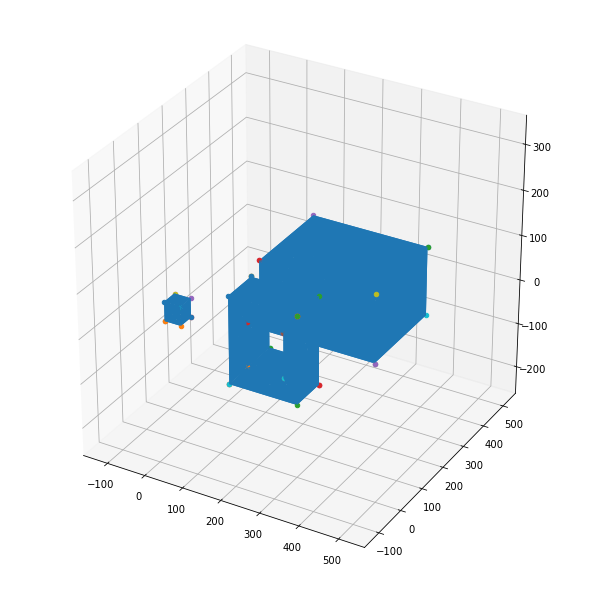

In [17]:
#p = QuadTree([-650,-650,350,350,-650,350])
p = QuadTree([-150,-150,550,550,-250,350])
a = mesh.Mesh.from_file("cubes.stl")
#a = mesh.Mesh.from_file("книжная полка.stl")
i = 0
for vect in a.vectors:
    v1 = Vector(vect[0],i)
    v2 = Vector(vect[1],i)
    v3 = Vector(vect[2],i)
    p.add_poly([v1,v2,v3])
    i+=1
    #print('\n')
p.show_poly()
p.show_node_center()
#clipper - библиотека

In [18]:
# q = QuadTree([-50,-50,150,150,-50,150])

# v1 = Vector([-1,-1,-1],0)
# v2 = Vector([-1,-2,-1],1)
# v3 = Vector([2,1,2],2)

# v4 = Vector([1,1,1],3)
# v5 = Vector([60,70,1],4)
# v6 = Vector([70,60,1],5)
# q.add_poly([v1,v2,v3])
# q.add_poly([v4,v5,v6])

# q.show_poly()

In [19]:
import numpy as np

def surface_normal_newell(poly):

    n = np.array([0.0, 0.0, 0.0])

    for i, v_curr in enumerate(poly):
        v_next = poly[(i+1) % len(poly),:]
        n[0] += (v_curr[1] - v_next[1]) * (v_curr[2] + v_next[2]) 
        n[1] += (v_curr[2] - v_next[2]) * (v_curr[0] + v_next[0])
        n[2] += (v_curr[0] - v_next[0]) * (v_curr[1] + v_next[1])

    norm = np.linalg.norm(n)
    if norm==0:
        raise ValueError('zero norm')
    else:
        normalised = n/norm

    return normalised

def test_surface_normal1():
    poly = np.array([[0,1,0],
                     [0,1,1],
                     [0,0,0]])
    print ("Newell:", surface_normal_newell(poly))

a = test_surface_normal1()

Newell: [1. 0. 0.]


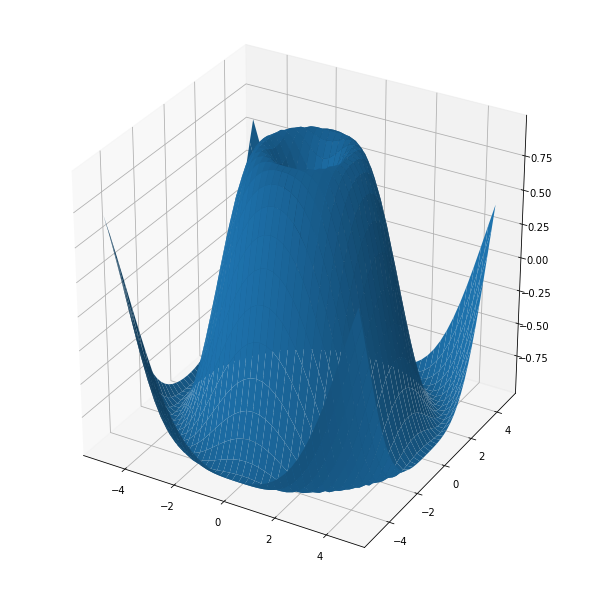

In [20]:
fig = plt.figure(figsize = [8,8])
ax = Axes3D(fig)
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z)